In [249]:
# # # !pip install mljar-supervised
# # !pip install boruta
# !pip install catboost
# !pip install fancyimpute
# !wget https://he-s3.s3.ap-southeast-1.amazonaws.com/media/hackathon/amexpert-code-lab/credit-card-default-risk-5-95cbc85f/892bcbe6493411ec.zip
# !unzip /content/892bcbe6493411ec.zip

In [250]:
from google.colab import output
output.enable_custom_widget_manager()

In [251]:
import pandas as pd
import numpy as np
import seaborn as sns

In [173]:
train=pd.read_csv("/content/dataset/train.csv")
train.head()

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_115179,ita Bose,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,CST_121920,Alper Jonathan,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0
2,CST_109330,Umesh Desai,37,M,N,Y,0.0,230153.17,204.0,Laborers,2.0,0.0,48416.60,41598.36,43,650.0,0,0,0
3,CST_128288,Rie,39,F,N,Y,0.0,122325.82,11941.0,Core staff,2.0,0.0,22574.36,32627.76,20,754.0,0,0,0
4,CST_151355,McCool,46,M,Y,Y,0.0,387286.00,1459.0,Core staff,1.0,0.0,38282.95,52950.64,75,927.0,0,0,0


In [174]:
test=pd.read_csv("/content/dataset/test.csv")
test.head()

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months
0,CST_142525,Siva,52,F,Y,N,0.0,232640.53,998.0,Unknown,2.0,0.0,14406.73,26524.40,4,779.0,0,0
1,CST_129215,Scott,48,F,N,N,1.0,284396.79,1338.0,Unknown,3.0,0.0,57479.99,68998.72,70,806.0,0,0
2,CST_138443,Victoria,50,F,N,N,1.0,149419.28,1210.0,Unknown,3.0,0.0,21611.01,25187.80,71,528.0,2,0
3,CST_123812,John McCrank,30,F,N,N,1.0,160437.54,503.0,Laborers,2.0,1.0,28990.76,29179.39,9,815.0,0,0
4,CST_144450,Martinne,52,M,N,Y,0.0,233480.37,157.0,Laborers,2.0,1.0,54213.72,82331.82,82,613.0,1,1


In [175]:
sample=pd.read_csv("/content/dataset/sample_submission.csv")
sample.head()

,customer_id,credit_card_default
0,CST_115179,1
1,CST_121920,0
2,CST_109330,0
3,CST_128288,0
4,CST_151355,0


In [176]:
train.shape

(45528, 19)

In [177]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45528 entries, 0 to 45527
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              45528 non-null  object 
 1   name                     45528 non-null  object 
 2   age                      45528 non-null  int64  
 3   gender                   45528 non-null  object 
 4   owns_car                 44981 non-null  object 
 5   owns_house               45528 non-null  object 
 6   no_of_children           44754 non-null  float64
 7   net_yearly_income        45528 non-null  float64
 8   no_of_days_employed      45065 non-null  float64
 9   occupation_type          45528 non-null  object 
 10  total_family_members     45445 non-null  float64
 11  migrant_worker           45441 non-null  float64
 12  yearly_debt_payments     45433 non-null  float64
 13  credit_limit             45528 non-null  float64
 14  credit_limit_used(%)  

In [178]:
train.describe()

,age,no_of_children,net_yearly_income,no_of_days_employed,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
count,45528.000000,44754.000000,4.552800e+04,45065.000000,45445.000000,45441.000000,45433.000000,4.552800e+04,45528.00000,45520.000000,45528.000000,45528.000000,45528.000000
mean,38.993411,0.420655,2.006556e+05,67609.289293,2.158081,0.179111,31796.965311,4.354842e+04,52.23502,782.791257,0.060710,0.050540,0.081203
std,9.543990,0.724097,6.690740e+05,139323.524434,0.911572,0.383450,17269.727234,1.487847e+05,29.37691,100.619746,0.264629,0.219059,0.273149
min,23.000000,0.000000,2.717061e+04,2.000000,1.000000,0.000000,2237.470000,4.003140e+03,0.00000,500.000000,0.000000,0.000000,0.000000
25%,31.000000,0.000000,1.263458e+05,936.000000,2.000000,0.000000,19231.140000,2.397381e+04,27.00000,704.000000,0.000000,0.000000,0.000000
50%,39.000000,0.000000,1.717149e+05,2224.000000,2.000000,0.000000,29081.650000,3.568804e+04,54.00000,786.000000,0.000000,0.000000,0.000000
75%,47.000000,1.000000,2.406038e+05,5817.000000,3.000000,0.000000,40561.150000,5.343576e+04,78.00000,867.000000,0.000000,0.000000,0.000000
max,55.000000,9.000000,1.407590e+08,365252.000000,10.000000,1.000000,328112.860000,3.112997e+07,99.00000,949.000000,2.000000,1.000000,1.000000


In [179]:
train.isnull().sum()

customer_id                  0
name                         0
age                          0
gender                       0
owns_car                   547
owns_house                   0
no_of_children             774
net_yearly_income            0
no_of_days_employed        463
occupation_type              0
total_family_members        83
migrant_worker              87
yearly_debt_payments        95
credit_limit                 0
credit_limit_used(%)         0
credit_score                 8
prev_defaults                0
default_in_last_6months      0
credit_card_default          0
dtype: int64

In [180]:
train.nunique()

customer_id                45528
name                        4010
age                           33
gender                         3
owns_car                       2
owns_house                     2
no_of_children                10
net_yearly_income          45502
no_of_days_employed         7874
occupation_type               19
total_family_members          10
migrant_worker                 2
yearly_debt_payments       45251
credit_limit               45371
credit_limit_used(%)         100
credit_score                 450
prev_defaults                  3
default_in_last_6months        2
credit_card_default            2
dtype: int64

In [181]:
t=pd.DataFrame(columns=['Column','Unique Values'])
for i in train.columns:
  t = t.append({'Column': i,'Unique Values': train[i].unique()}, ignore_index=True)
t

,Column,Unique Values
0,customer_id,"[CST_115179, CST_121920, CST_109330, CST_12828..."
1,name,"[ita Bose, Alper Jonathan, Umesh Desai, Rie, M..."
2,age,"[46, 29, 37, 39, 38, 40, 32, 52, 43, 24, 41, 3..."
3,gender,"[F, M, XNA]"
4,owns_car,"[N, Y, nan]"
5,owns_house,"[Y, N]"
6,no_of_children,"[0.0, 1.0, 2.0, nan, 3.0, 4.0, 5.0, 6.0, 7.0, ..."
7,net_yearly_income,"[107934.04, 109862.62, 230153.17, 122325.82, 3..."
8,no_of_days_employed,"[612.0, 2771.0, 204.0, 11941.0, 1459.0, 2898.0..."
9,occupation_type,"[Unknown, Laborers, Core staff, Accountants, H..."


In [182]:
t=pd.DataFrame(columns=['Column','Unique Count'])
for i in train.columns:
  t = t.append({'Column': i,'Unique Count': train[i].nunique()}, ignore_index=True)
t

,Column,Unique Count
0,customer_id,45528
1,name,4010
2,age,33
3,gender,3
4,owns_car,2
5,owns_house,2
6,no_of_children,10
7,net_yearly_income,45502
8,no_of_days_employed,7874
9,occupation_type,19


In [183]:
for i in train.columns:
  if(train[i].dtype=='object'):
    display(train[i].value_counts())

CST_151590    1
CST_102974    1
CST_112092    1
CST_135266    1
CST_117017    1
             ..
CST_124356    1
CST_160871    1
CST_103210    1
CST_148888    1
CST_146061    1
Name: customer_id, Length: 45528, dtype: int64

Jonathan               207
Jonathan Stempel       192
David                  170
Stempel                165
Jessica                162
                      ... 
Golovnina                1
Pawel Bernat             1
Evren Ballim             1
Suleiman Al-Khalidi      1
Garibian                 1
Name: name, Length: 4010, dtype: int64

F      29957
M      15570
XNA        1
Name: gender, dtype: int64

N    29743
Y    15238
Name: owns_car, dtype: int64

Y    31642
N    13886
Name: owns_house, dtype: int64

Unknown                  14299
Laborers                  8134
Sales staff               4725
Core staff                4062
Managers                  3168
Drivers                   2747
High skill tech staff     1682
Accountants               1474
Medicine staff            1275
Security staff            1025
Cooking staff              902
Cleaning staff             665
Private service staff      387
Low-skill Laborers         336
Waiters/barmen staff       203
Secretaries                199
Realty agents              101
HR staff                    78
IT staff                    66
Name: occupation_type, dtype: int64

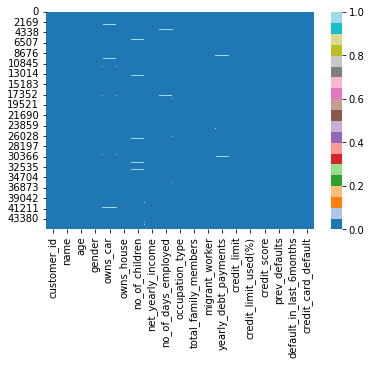

In [184]:
sns.heatmap(data=train.isnull(),cmap="tab20")

In [185]:
# train.fillna(train.select_dtypes(include='number').mean().iloc[0], inplace=True)
# train.fillna(train.select_dtypes(include='object').mode().iloc[0], inplace=True)

In [186]:
# sns.heatmap(data=train.isnull(),cmap="tab20")

In [187]:
# train=pd.DataFrame({col: train[col].astype('category').cat.codes for col in train}, index=train.index)

In [188]:
test.head()

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months
0,CST_142525,Siva,52,F,Y,N,0.0,232640.53,998.0,Unknown,2.0,0.0,14406.73,26524.40,4,779.0,0,0
1,CST_129215,Scott,48,F,N,N,1.0,284396.79,1338.0,Unknown,3.0,0.0,57479.99,68998.72,70,806.0,0,0
2,CST_138443,Victoria,50,F,N,N,1.0,149419.28,1210.0,Unknown,3.0,0.0,21611.01,25187.80,71,528.0,2,0
3,CST_123812,John McCrank,30,F,N,N,1.0,160437.54,503.0,Laborers,2.0,1.0,28990.76,29179.39,9,815.0,0,0
4,CST_144450,Martinne,52,M,N,Y,0.0,233480.37,157.0,Laborers,2.0,1.0,54213.72,82331.82,82,613.0,1,1


In [189]:
final=pd.DataFrame()
final['customer_id']=test['customer_id']

In [190]:
test.shape

(11383, 18)

In [191]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11383 entries, 0 to 11382
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              11383 non-null  object 
 1   name                     11383 non-null  object 
 2   age                      11383 non-null  int64  
 3   gender                   11383 non-null  object 
 4   owns_car                 11251 non-null  object 
 5   owns_house               11383 non-null  object 
 6   no_of_children           11193 non-null  float64
 7   net_yearly_income        11383 non-null  float64
 8   no_of_days_employed      11278 non-null  float64
 9   occupation_type          11383 non-null  object 
 10  total_family_members     11352 non-null  float64
 11  migrant_worker           11357 non-null  float64
 12  yearly_debt_payments     11361 non-null  float64
 13  credit_limit             11383 non-null  float64
 14  credit_limit_used(%)  

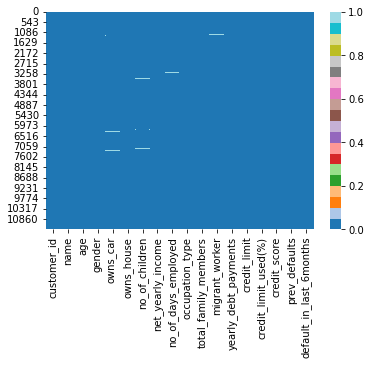

In [192]:
sns.heatmap(data=test.isnull(),cmap="tab20")

In [193]:
test.isnull().sum()

customer_id                  0
name                         0
age                          0
gender                       0
owns_car                   132
owns_house                   0
no_of_children             190
net_yearly_income            0
no_of_days_employed        105
occupation_type              0
total_family_members        31
migrant_worker              26
yearly_debt_payments        22
credit_limit                 0
credit_limit_used(%)         0
credit_score                 3
prev_defaults                0
default_in_last_6months      0
dtype: int64

In [194]:
test.describe()

,age,no_of_children,net_yearly_income,no_of_days_employed,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months
count,11383.000000,11193.000000,1.138300e+04,11278.000000,11352.000000,11357.000000,11361.000000,11383.000000,11383.000000,11380.000000,11383.000000,11383.000000
mean,39.073004,0.419012,1.987084e+05,65519.798280,2.157593,0.178040,32078.968043,42972.207247,51.780989,784.389455,0.058069,0.048669
std,9.572474,0.727709,1.151905e+05,137572.106971,0.917391,0.382563,17417.412533,29325.712903,29.386130,100.468636,0.260202,0.215185
min,23.000000,0.000000,3.030994e+04,-3.000000,1.000000,0.000000,2371.740000,3604.650000,0.000000,500.000000,0.000000,0.000000
25%,31.000000,0.000000,1.274479e+05,934.250000,2.000000,0.000000,19522.320000,24148.525000,26.000000,705.000000,0.000000,0.000000
50%,39.000000,0.000000,1.728695e+05,2216.000000,2.000000,0.000000,29246.110000,35793.490000,53.000000,787.000000,0.000000,0.000000
75%,47.000000,1.000000,2.402339e+05,5517.000000,3.000000,0.000000,40729.260000,53527.890000,78.000000,870.000000,0.000000,0.000000
max,55.000000,11.000000,2.472450e+06,365252.000000,13.000000,1.000000,280114.740000,421517.090000,99.000000,949.000000,2.000000,1.000000


In [195]:
t=pd.DataFrame(columns=['Column','Unique Values'])
for i in test.columns:
  t = t.append({'Column': i,'Unique Values': test[i].unique()}, ignore_index=True)
t

,Column,Unique Values
0,customer_id,"[CST_142525, CST_129215, CST_138443, CST_12381..."
1,name,"[Siva, Scott, Victoria, John McCrank, Martinne..."
2,age,"[52, 48, 50, 30, 29, 37, 41, 27, 25, 51, 47, 4..."
3,gender,"[F, M, XNA]"
4,owns_car,"[Y, N, nan]"
5,owns_house,"[N, Y]"
6,no_of_children,"[0.0, 1.0, 2.0, nan, 3.0, 5.0, 4.0, 7.0, 11.0]"
7,net_yearly_income,"[232640.53, 284396.79, 149419.28, 160437.54, 2..."
8,no_of_days_employed,"[998.0, 1338.0, 1210.0, 503.0, 157.0, 4794.0, ..."
9,occupation_type,"[Unknown, Laborers, Sales staff, Medicine staf..."


In [196]:
t=pd.DataFrame(columns=['Column','Unique Count'])
for i in test.columns:
  t = t.append({'Column': i,'Unique Count': test[i].nunique()}, ignore_index=True)
t

,Column,Unique Count
0,customer_id,11383
1,name,2459
2,age,33
3,gender,3
4,owns_car,2
5,owns_house,2
6,no_of_children,8
7,net_yearly_income,11380
8,no_of_days_employed,4558
9,occupation_type,19


In [197]:
# test.fillna(test.select_dtypes(include='number').mean().iloc[0], inplace=True)
# test.fillna(test.select_dtypes(include='object').mode().iloc[0], inplace=True)

In [198]:
# sns.heatmap(data=test.isnull(),cmap="tab20")

In [199]:
# test=pd.DataFrame({col: test[col].astype('category').cat.codes for col in test}, index=test.index)

In [200]:
data=train.append(test).drop(columns=['credit_card_default'])

In [201]:
data.isnull().sum()

customer_id                  0
name                         0
age                          0
gender                       0
owns_car                   679
owns_house                   0
no_of_children             964
net_yearly_income            0
no_of_days_employed        568
occupation_type              0
total_family_members       114
migrant_worker             113
yearly_debt_payments       117
credit_limit                 0
credit_limit_used(%)         0
credit_score                11
prev_defaults                0
default_in_last_6months      0
dtype: int64

In [202]:
# data

In [203]:
# data=pd.DataFrame({col: data[col].astype('category').cat.codes for col in data}, index=data.index)

In [204]:
# data

In [205]:
# data.isnull().sum()

In [206]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# imp_mean = IterativeImputer(random_state=0)
# imp_mean.fit(data)
# imputed_both = pd.DataFrame(imp_mean.transform(data))
# imputed_both.columns = data.columns
# data=imputed_both

# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=2, weights="uniform")
# KNN_imp = pd.DataFrame(np.round(imputer.fit_transform(both_data)))
# imputed_both=KNN_imp
# imputed_both.columns = data.columns

In [207]:
data.isnull().sum()

customer_id                  0
name                         0
age                          0
gender                       0
owns_car                   679
owns_house                   0
no_of_children             964
net_yearly_income            0
no_of_days_employed        568
occupation_type              0
total_family_members       114
migrant_worker             113
yearly_debt_payments       117
credit_limit                 0
credit_limit_used(%)         0
credit_score                11
prev_defaults                0
default_in_last_6months      0
dtype: int64

In [208]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56911 entries, 0 to 11382
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              56911 non-null  object 
 1   name                     56911 non-null  object 
 2   age                      56911 non-null  int64  
 3   gender                   56911 non-null  object 
 4   owns_car                 56232 non-null  object 
 5   owns_house               56911 non-null  object 
 6   no_of_children           55947 non-null  float64
 7   net_yearly_income        56911 non-null  float64
 8   no_of_days_employed      56343 non-null  float64
 9   occupation_type          56911 non-null  object 
 10  total_family_members     56797 non-null  float64
 11  migrant_worker           56798 non-null  float64
 12  yearly_debt_payments     56794 non-null  float64
 13  credit_limit             56911 non-null  float64
 14  credit_limit_used(%)  

In [209]:
data.head()

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months
0,CST_115179,ita Bose,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1
1,CST_121920,Alper Jonathan,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0
2,CST_109330,Umesh Desai,37,M,N,Y,0.0,230153.17,204.0,Laborers,2.0,0.0,48416.60,41598.36,43,650.0,0,0
3,CST_128288,Rie,39,F,N,Y,0.0,122325.82,11941.0,Core staff,2.0,0.0,22574.36,32627.76,20,754.0,0,0
4,CST_151355,McCool,46,M,Y,Y,0.0,387286.00,1459.0,Core staff,1.0,0.0,38282.95,52950.64,75,927.0,0,0


In [210]:
# data.fillna(data.select_dtypes(include='float').mean().iloc[0], inplace=True)
# data.fillna(data.select_dtypes(include=['object','int']).mode().iloc[0], inplace=True)

In [211]:
data.isnull().sum()

customer_id                  0
name                         0
age                          0
gender                       0
owns_car                   679
owns_house                   0
no_of_children             964
net_yearly_income            0
no_of_days_employed        568
occupation_type              0
total_family_members       114
migrant_worker             113
yearly_debt_payments       117
credit_limit                 0
credit_limit_used(%)         0
credit_score                11
prev_defaults                0
default_in_last_6months      0
dtype: int64

In [212]:
gang=['age','gender','owns_car','owns_house','no_of_children','occupation_type','total_family_members','migrant_worker','credit_limit_used(%)','prev_defaults','default_in_last_6months']
# gang=['gender','owns_car','owns_house','no_of_children','occupation_type','total_family_members','migrant_worker','prev_defaults','default_in_last_6months']
cat_data=pd.DataFrame()
for i in gang:
  status=pd.get_dummies(data[i],prefix=i,drop_first=True)
  for j in status:
    status[j] = status[j].astype(int)
  status.loc[data[i].isnull(),status.columns.str.startswith(i+"_")] = np.nan
  # for j in status.columns:
  #   status[j] = status[j].fillna(status[j].mode()[0])
  cat_data=pd.concat([cat_data,status],axis=1)
data=pd.concat([data,cat_data],axis=1)
data.drop(columns=gang,axis=1,inplace=True)

In [213]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56911 entries, 0 to 11382
Columns: 184 entries, customer_id to default_in_last_6months_1
dtypes: float64(182), object(2)
memory usage: 80.3+ MB


In [214]:
data.isnull().sum()

customer_id                    0
name                           0
net_yearly_income              0
no_of_days_employed          568
yearly_debt_payments         117
                            ... 
credit_limit_used(%)_98        0
credit_limit_used(%)_99        0
prev_defaults_1                0
prev_defaults_2                0
default_in_last_6months_1      0
Length: 184, dtype: int64

In [215]:
data

,customer_id,name,net_yearly_income,no_of_days_employed,yearly_debt_payments,credit_limit,credit_score,age_24,age_25,age_26,age_27,age_28,age_29,age_30,age_31,age_32,age_33,age_34,age_35,age_36,age_37,age_38,age_39,age_40,age_41,age_42,age_43,age_44,age_45,age_46,age_47,age_48,age_49,age_50,age_51,age_52,age_53,age_54,age_55,gender_M,...,credit_limit_used(%)_63,credit_limit_used(%)_64,credit_limit_used(%)_65,credit_limit_used(%)_66,credit_limit_used(%)_67,credit_limit_used(%)_68,credit_limit_used(%)_69,credit_limit_used(%)_70,credit_limit_used(%)_71,credit_limit_used(%)_72,credit_limit_used(%)_73,credit_limit_used(%)_74,credit_limit_used(%)_75,credit_limit_used(%)_76,credit_limit_used(%)_77,credit_limit_used(%)_78,credit_limit_used(%)_79,credit_limit_used(%)_80,credit_limit_used(%)_81,credit_limit_used(%)_82,credit_limit_used(%)_83,credit_limit_used(%)_84,credit_limit_used(%)_85,credit_limit_used(%)_86,credit_limit_used(%)_87,credit_limit_used(%)_88,credit_limit_used(%)_89,credit_limit_used(%)_90,credit_limit_used(%)_91,credit_limit_used(%)_92,credit_limit_used(%)_93,credit_limit_used(%)_94,credit_limit_used(%)_95,credit_limit_used(%)_96,credit_limit_used(%)_97,credit_limit_used(%)_98,credit_limit_used(%)_99,prev_defaults_1,prev_defaults_2,default_in_last_6months_1
0,CST_115179,ita Bose,107934.04,612.0,33070.28,18690.93,544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,CST_121920,Alper Jonathan,109862.62,2771.0,15329.53,37745.19,857.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CST_109330,Umesh Desai,230153.17,204.0,48416.60,41598.36,650.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CST_128288,Rie,122325.82,11941.0,22574.36,32627.76,754.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CST_151355,McCool,387286.00,1459.0,38282.95,52950.64,927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,CST_142412,Solarina,266824.38,3051.0,17791.56,64483.93,823.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11379,CST_107967,Jonathan Cable,124310.85,365248.0,26576.79,29851.73,712.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,

In [216]:
# data=data.dropna()

In [217]:
# data.isnull().sum()

In [218]:
# data=data.reset_index(drop=True)

In [219]:
data

,customer_id,name,net_yearly_income,no_of_days_employed,yearly_debt_payments,credit_limit,credit_score,age_24,age_25,age_26,age_27,age_28,age_29,age_30,age_31,age_32,age_33,age_34,age_35,age_36,age_37,age_38,age_39,age_40,age_41,age_42,age_43,age_44,age_45,age_46,age_47,age_48,age_49,age_50,age_51,age_52,age_53,age_54,age_55,gender_M,...,credit_limit_used(%)_63,credit_limit_used(%)_64,credit_limit_used(%)_65,credit_limit_used(%)_66,credit_limit_used(%)_67,credit_limit_used(%)_68,credit_limit_used(%)_69,credit_limit_used(%)_70,credit_limit_used(%)_71,credit_limit_used(%)_72,credit_limit_used(%)_73,credit_limit_used(%)_74,credit_limit_used(%)_75,credit_limit_used(%)_76,credit_limit_used(%)_77,credit_limit_used(%)_78,credit_limit_used(%)_79,credit_limit_used(%)_80,credit_limit_used(%)_81,credit_limit_used(%)_82,credit_limit_used(%)_83,credit_limit_used(%)_84,credit_limit_used(%)_85,credit_limit_used(%)_86,credit_limit_used(%)_87,credit_limit_used(%)_88,credit_limit_used(%)_89,credit_limit_used(%)_90,credit_limit_used(%)_91,credit_limit_used(%)_92,credit_limit_used(%)_93,credit_limit_used(%)_94,credit_limit_used(%)_95,credit_limit_used(%)_96,credit_limit_used(%)_97,credit_limit_used(%)_98,credit_limit_used(%)_99,prev_defaults_1,prev_defaults_2,default_in_last_6months_1
0,CST_115179,ita Bose,107934.04,612.0,33070.28,18690.93,544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,CST_121920,Alper Jonathan,109862.62,2771.0,15329.53,37745.19,857.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CST_109330,Umesh Desai,230153.17,204.0,48416.60,41598.36,650.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CST_128288,Rie,122325.82,11941.0,22574.36,32627.76,754.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CST_151355,McCool,387286.00,1459.0,38282.95,52950.64,927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,CST_142412,Solarina,266824.38,3051.0,17791.56,64483.93,823.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11379,CST_107967,Jonathan Cable,124310.85,365248.0,26576.79,29851.73,712.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,

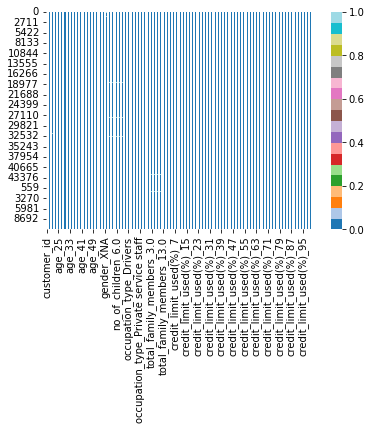

In [220]:
sns.heatmap(data=data.isnull(),cmap="tab20")

In [221]:
data.fillna(data.select_dtypes(include='float').mean().iloc[0], inplace=True)
data.fillna(data.select_dtypes(include='int').mode().iloc[0], inplace=True)

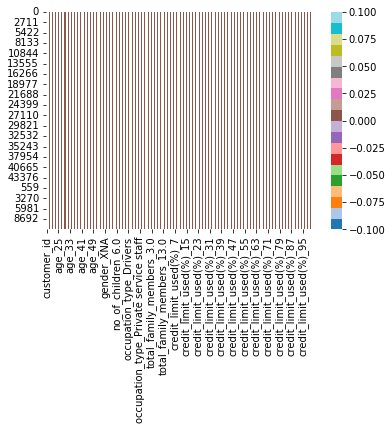

In [222]:
sns.heatmap(data=data.isnull(),cmap="tab20")

In [223]:
data

,customer_id,name,net_yearly_income,no_of_days_employed,yearly_debt_payments,credit_limit,credit_score,age_24,age_25,age_26,age_27,age_28,age_29,age_30,age_31,age_32,age_33,age_34,age_35,age_36,age_37,age_38,age_39,age_40,age_41,age_42,age_43,age_44,age_45,age_46,age_47,age_48,age_49,age_50,age_51,age_52,age_53,age_54,age_55,gender_M,...,credit_limit_used(%)_63,credit_limit_used(%)_64,credit_limit_used(%)_65,credit_limit_used(%)_66,credit_limit_used(%)_67,credit_limit_used(%)_68,credit_limit_used(%)_69,credit_limit_used(%)_70,credit_limit_used(%)_71,credit_limit_used(%)_72,credit_limit_used(%)_73,credit_limit_used(%)_74,credit_limit_used(%)_75,credit_limit_used(%)_76,credit_limit_used(%)_77,credit_limit_used(%)_78,credit_limit_used(%)_79,credit_limit_used(%)_80,credit_limit_used(%)_81,credit_limit_used(%)_82,credit_limit_used(%)_83,credit_limit_used(%)_84,credit_limit_used(%)_85,credit_limit_used(%)_86,credit_limit_used(%)_87,credit_limit_used(%)_88,credit_limit_used(%)_89,credit_limit_used(%)_90,credit_limit_used(%)_91,credit_limit_used(%)_92,credit_limit_used(%)_93,credit_limit_used(%)_94,credit_limit_used(%)_95,credit_limit_used(%)_96,credit_limit_used(%)_97,credit_limit_used(%)_98,credit_limit_used(%)_99,prev_defaults_1,prev_defaults_2,default_in_last_6months_1
0,CST_115179,ita Bose,107934.04,612.0,33070.28,18690.93,544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,CST_121920,Alper Jonathan,109862.62,2771.0,15329.53,37745.19,857.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CST_109330,Umesh Desai,230153.17,204.0,48416.60,41598.36,650.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CST_128288,Rie,122325.82,11941.0,22574.36,32627.76,754.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CST_151355,McCool,387286.00,1459.0,38282.95,52950.64,927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,CST_142412,Solarina,266824.38,3051.0,17791.56,64483.93,823.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11379,CST_107967,Jonathan Cable,124310.85,365248.0,26576.79,29851.73,712.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,

In [224]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# le.fit(data['customer_id'])
# data['customer_id']=le.transform(data['customer_id'])
# le.fit(data['name'])
# data['name']=le.transform(data['name'])

In [225]:
# for i in data.columns:
#   train[i]=data[i].iloc[:45528]
#   test[i]=data[i].iloc[45528:]
temp_train=pd.DataFrame()
temp_train['credit_card_default']=train['credit_card_default']
train=pd.DataFrame()
test=pd.DataFrame()
for i in data.columns:
  train[i]=data[i].iloc[:45528]
  test[i]=data[i].iloc[45528:]
train['credit_card_default']=temp_train['credit_card_default']

In [226]:
# from scipy.stats import zscore
# temp=train.drop(columns=['credit_card_default'])
# z_scores = zscore(temp)
# abs_z_scores = np.abs(z_scores)
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# temp = temp[filtered_entries]
# temp['credit_card_default']=train['credit_card_default'][filtered_entries]
# train=temp

### Feature Selection Method 1

In [227]:
data

,customer_id,name,net_yearly_income,no_of_days_employed,yearly_debt_payments,credit_limit,credit_score,age_24,age_25,age_26,age_27,age_28,age_29,age_30,age_31,age_32,age_33,age_34,age_35,age_36,age_37,age_38,age_39,age_40,age_41,age_42,age_43,age_44,age_45,age_46,age_47,age_48,age_49,age_50,age_51,age_52,age_53,age_54,age_55,gender_M,...,credit_limit_used(%)_63,credit_limit_used(%)_64,credit_limit_used(%)_65,credit_limit_used(%)_66,credit_limit_used(%)_67,credit_limit_used(%)_68,credit_limit_used(%)_69,credit_limit_used(%)_70,credit_limit_used(%)_71,credit_limit_used(%)_72,credit_limit_used(%)_73,credit_limit_used(%)_74,credit_limit_used(%)_75,credit_limit_used(%)_76,credit_limit_used(%)_77,credit_limit_used(%)_78,credit_limit_used(%)_79,credit_limit_used(%)_80,credit_limit_used(%)_81,credit_limit_used(%)_82,credit_limit_used(%)_83,credit_limit_used(%)_84,credit_limit_used(%)_85,credit_limit_used(%)_86,credit_limit_used(%)_87,credit_limit_used(%)_88,credit_limit_used(%)_89,credit_limit_used(%)_90,credit_limit_used(%)_91,credit_limit_used(%)_92,credit_limit_used(%)_93,credit_limit_used(%)_94,credit_limit_used(%)_95,credit_limit_used(%)_96,credit_limit_used(%)_97,credit_limit_used(%)_98,credit_limit_used(%)_99,prev_defaults_1,prev_defaults_2,default_in_last_6months_1
0,CST_115179,ita Bose,107934.04,612.0,33070.28,18690.93,544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,CST_121920,Alper Jonathan,109862.62,2771.0,15329.53,37745.19,857.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CST_109330,Umesh Desai,230153.17,204.0,48416.60,41598.36,650.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CST_128288,Rie,122325.82,11941.0,22574.36,32627.76,754.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CST_151355,McCool,387286.00,1459.0,38282.95,52950.64,927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,CST_142412,Solarina,266824.38,3051.0,17791.56,64483.93,823.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11379,CST_107967,Jonathan Cable,124310.85,365248.0,26576.79,29851.73,712.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,

In [228]:
l=[]
# l=abs(train.corr()["credit_card_default"][abs(train.corr()["credit_card_default"])>0.03].drop('credit_card_default')).index.tolist()

### Feature Selection Method 2

In [229]:
# X=train.drop(columns=['credit_card_default','customer_id','name'])
# Y=train['credit_card_default']

In [230]:
# !pip install boruta

In [231]:
# %%time
# from boruta import BorutaPy
# from sklearn.ensemble import RandomForestClassifier
# forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
# # forest.fit(X, Y)
# feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1)
# feat_selector.fit(X.values, Y.values)
# # check selected features
# feat_selector.support_
# # check ranking of features
# feat_selector.ranking_

In [232]:
# feature_ranks = list(zip(X.columns, 
#                          feat_selector.ranking_, 
#                          feat_selector.support_))

# # iterate through and print out the results
# for feat in feature_ranks:
#     print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

In [233]:
# for feat in feature_ranks:
#   if(feat[2]==False):
#     l.append(feat[0])
#     # print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

In [234]:
# l=['name','age','owns_car','owns_house','no_of_children','total_family_members','migrant_worker']

In [235]:
l=l+['customer_id','name']

## Training Data

In [236]:
# l.append('credit_card_default')
# l.append('customer_id')
# l.append('name')
# x = train.drop(columns=l)
# y = train['credit_card_default']
# l.remove('credit_card_default')
# z = test.drop(columns=l)

In [237]:
train.drop(columns=l,inplace=True)
test.drop(columns=l,inplace=True)

In [238]:
train

,net_yearly_income,no_of_days_employed,yearly_debt_payments,credit_limit,credit_score,age_24,age_25,age_26,age_27,age_28,age_29,age_30,age_31,age_32,age_33,age_34,age_35,age_36,age_37,age_38,age_39,age_40,age_41,age_42,age_43,age_44,age_45,age_46,age_47,age_48,age_49,age_50,age_51,age_52,age_53,age_54,age_55,gender_M,gender_XNA,owns_car_Y,...,credit_limit_used(%)_64,credit_limit_used(%)_65,credit_limit_used(%)_66,credit_limit_used(%)_67,credit_limit_used(%)_68,credit_limit_used(%)_69,credit_limit_used(%)_70,credit_limit_used(%)_71,credit_limit_used(%)_72,credit_limit_used(%)_73,credit_limit_used(%)_74,credit_limit_used(%)_75,credit_limit_used(%)_76,credit_limit_used(%)_77,credit_limit_used(%)_78,credit_limit_used(%)_79,credit_limit_used(%)_80,credit_limit_used(%)_81,credit_limit_used(%)_82,credit_limit_used(%)_83,credit_limit_used(%)_84,credit_limit_used(%)_85,credit_limit_used(%)_86,credit_limit_used(%)_87,credit_limit_used(%)_88,credit_limit_used(%)_89,credit_limit_used(%)_90,credit_limit_used(%)_91,credit_limit_used(%)_92,credit_limit_used(%)_93,credit_limit_used(%)_94,credit_limit_used(%)_95,credit_limit_used(%)_96,credit_limit_used(%)_97,credit_limit_used(%)_98,credit_limit_used(%)_99,prev_defaults_1,prev_defaults_2,default_in_last_6months_1,credit_card_default
0,107934.04,612.0,33070.28,18690.93,544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
1,109862.62,2771.0,15329.53,37745.19,857.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,230153.17,204.0,48416.60,41598.36,650.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,122325.82,11941.0,22574.36,32627.76,754.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,387286.00,1459.0,38282.95,52950.64,927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45523,96207.57,117.0,11229.54,29663.83,907.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
45524,383476.74,966.0,43369.91,139947.16,679.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [239]:
# train=train.dropna()
# train=train.reset_index(drop=True)
# test.fillna(test.select_dtypes(include='float').mean().iloc[0], inplace=True)

In [240]:
x=train.drop(columns=['credit_card_default'])
# x.drop(columns=l,axis=1,inplace=True)
y=train['credit_card_default']
z=test
# z.drop(columns=l,axis=1,inplace=True)

In [241]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3,random_state=0)

In [242]:
print("X_train: {}".format(X_train.shape))
print("X_test: {}".format(X_test.shape))
print("Y_train: {}".format(y_train.shape))
print("Y_test: {}".format(y_test.shape))

X_train: (31869, 182)
X_test: (13659, 182)
Y_train: (31869,)
Y_test: (13659,)


In [243]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_train_pred=logistic_regression.predict(X_train)
y_pred=logistic_regression.predict(X_test)
print("##################### Test Accuracy #####################")
print(classification_report(y_test, y_pred))
print("#########################################################")
print("##################### Train Accuracy ####################")
print(classification_report(y_train,y_train_pred))
print("#########################################################")
print("################# Test Confusion Matrix #################")
print(confusion_matrix(y_test, y_pred))
print("################# Train Confusion Matrix ################")
print(confusion_matrix(y_train, y_train_pred))
print("#########################################################")

##################### Test Accuracy #####################
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     12578
           1       0.00      0.00      0.00      1081

    accuracy                           0.92     13659
   macro avg       0.46      0.50      0.48     13659
weighted avg       0.85      0.92      0.88     13659

#########################################################
##################### Train Accuracy ####################
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     29253
           1       0.00      0.00      0.00      2616

    accuracy                           0.92     31869
   macro avg       0.46      0.50      0.48     31869
weighted avg       0.84      0.92      0.88     31869

#########################################################
################# Test Confusion Matrix #################
[[12578     0]
 [ 1081     0]]
################# Train C

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

In [244]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
dt_train_pred = dt.predict(X_train)
dt_pred = dt.predict(X_test)
print("##################### Test Accuracy #####################")
print(classification_report(y_test, dt_pred))
print("#########################################################")
print("##################### Train Accuracy #####################")
print(classification_report(y_train, dt_train_pred))
print("#########################################################")
print("################# Test Confusion Matrix #################")
print(confusion_matrix(y_test, dt_pred))
print("################# Train Confusion Matrix ################")
print(confusion_matrix(y_train, dt_train_pred))
print("#########################################################")

##################### Test Accuracy #####################
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12578
           1       0.83      0.84      0.84      1081

    accuracy                           0.97     13659
   macro avg       0.91      0.91      0.91     13659
weighted avg       0.97      0.97      0.97     13659

#########################################################
##################### Train Accuracy #####################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29253
           1       1.00      1.00      1.00      2616

    accuracy                           1.00     31869
   macro avg       1.00      1.00      1.00     31869
weighted avg       1.00      1.00      1.00     31869

#########################################################
################# Test Confusion Matrix #################
[[12397   181]
 [  169   912]]
################# Train 

In [245]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc_pred=rfc.predict(X_test)
rfc_train_pred=rfc.predict(X_train)
print("##################### Test Accuracy #####################")
print(classification_report(y_test, rfc_pred))
print("#########################################################")
print("##################### Train Accuracy #####################")
print(classification_report(y_train, rfc_train_pred))
print("#########################################################")
print("################# Test Confusion Matrix #################")
print(confusion_matrix(y_test, rfc_pred))
print("################# Train Confusion Matrix ################")
print(confusion_matrix(y_train, rfc_train_pred))
print("#########################################################")

##################### Test Accuracy #####################
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12578
           1       1.00      0.77      0.87      1081

    accuracy                           0.98     13659
   macro avg       0.99      0.88      0.93     13659
weighted avg       0.98      0.98      0.98     13659

#########################################################
##################### Train Accuracy #####################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29253
           1       1.00      1.00      1.00      2616

    accuracy                           1.00     31869
   macro avg       1.00      1.00      1.00     31869
weighted avg       1.00      1.00      1.00     31869

#########################################################
################# Test Confusion Matrix #################
[[12578     0]
 [  249   832]]
################# Train 

In [246]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_test_pred = xgb.predict(X_train)
print(classification_report(y_test,y_pred))
print(classification_report(y_train,y_test_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12578
           1       1.00      0.77      0.87      1081

    accuracy                           0.98     13659
   macro avg       0.99      0.88      0.93     13659
weighted avg       0.98      0.98      0.98     13659

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     29253
           1       1.00      0.75      0.86      2616

    accuracy                           0.98     31869
   macro avg       0.99      0.88      0.92     31869
weighted avg       0.98      0.98      0.98     31869



### Prediction on Test Data

In [247]:
# from catboost import CatBoostClassifier
# from google.colab import output
# output.enable_custom_widget_manager()
# cat = CatBoostClassifier()
# grid = {
#           # 'learning_rate': [0.03, 0.1],
#           'depth': [5,10,11,12,13,15,16,17],
#           # 'l2_leaf_reg': [1, 3, 5, 7, 9]
#         }
# grid_search_result = cat.grid_search(grid,X=x,y=y,plot=True)

In [248]:
# grid_search_result['params']

In [262]:
from xgboost import XGBClassifier
cat = XGBClassifier()
cat.fit(x,y)
y_pred = cat.predict(z)
final['credit_card_default']=y_pred
final.to_csv("Final_Credit.csv",index=False)

# from xgboost import XGBClassifier
# xgb = XGBClassifier()
# # kfold = KFold(n_splits=10, random_state=7)
# xgb.fit(x,y)
# y_pred = xgb.predict(z)
# final['credit_card_default']=y_pred
# final.to_csv("Final_Credit.csv",index=False)

# from supervised.automl import AutoML
# automl = AutoML()
# automl.fit(x, y)
# y_pred = automl.predict(z)
# final['credit_card_default']=y_pred
# final.to_csv("Final_Credit.csv",index=False)

# from sklearn.neural_network import MLPClassifier
# clf = MLPClassifier()
# clf.fit(x, y)
# predictions=clf.predict(z)
# final['credit_card_default']=predictions
# final.to_csv("Final_Credit.csv",index=False)

In [253]:
from google.colab import output
output.enable_custom_widget_manager()

In [254]:
from google.colab import output
output.disable_custom_widget_manager()

In [255]:
len(y_pred)

11383

In [256]:
sample.head()

,customer_id,credit_card_default
0,CST_115179,1
1,CST_121920,0
2,CST_109330,0
3,CST_128288,0
4,CST_151355,0


In [257]:
final['credit_card_default']=y_pred
final.to_csv("Final_Credit.csv",index=False)

In [258]:
# while True: pass

[2.01729478e+00 3.67737208e+00 2.75086421e+00 1.95159629e+00
 7.24885571e+01 4.69659445e-02 1.55028716e-02 4.45001742e-02
 3.87902317e-02 2.99011123e-02 2.72933216e-02 1.24864438e-02
 9.36385397e-02 3.14945227e-02 1.88060111e-02 9.27912341e-02
 8.19440793e-02 2.87401900e-02 2.24650789e-02 7.08452908e-02
 2.47461894e-02 2.82730014e-02 1.16973744e-01 2.06781281e-02
 7.55279798e-02 1.98460049e-02 6.66401157e-03 8.21496860e-02
 5.49419382e-02 5.45988802e-02 1.02559802e-01 1.03975125e-01
 1.01444235e-01 5.43672438e-02 4.64709711e-02 4.57410998e-02
 1.45347577e-01 3.71145064e-01 1.16904076e-05 3.31640152e-01
 2.16346703e-01 9.66024983e-02 2.03185936e-01 1.59650358e-02
 1.79206217e-02 8.42480888e-03 5.45037921e-02 3.23954046e-03
 6.07967764e-02 9.39341900e-02 0.00000000e+00 4.39316582e-02
 8.67933707e-02 2.92717104e-01 9.70519879e-02 0.00000000e+00
 3.85491420e-02 0.00000000e+00 3.50235824e-01 4.46704290e-03
 5.43388108e-02 8.74315382e-03 2.96802384e-02 5.38117286e-03
 8.69202582e-02 1.785076

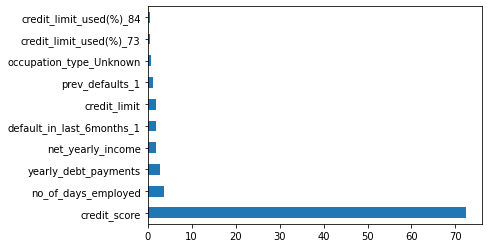

In [259]:
import matplotlib.pyplot as plt
print(cat.feature_importances_)
feat_importances = pd.Series(cat.feature_importances_, index=x.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()